In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import datetime

After importing our libraries, we read the CSV file containing information about solar power generated (MW) every 5 minutes for the whole year of 2006. We split the Date and Time information into new colums so we can later aggregate the total amount of power generated per day.

In [5]:
df = pd.read_csv('/Users/tareq/solar_panel_model/ny-pv-2006/Actual_40.85_-73.85_2006_DPV_21MW_5_Min.csv')
#url = 'https://github.com/Tareq62/solar_panel_model/blob/master/Actual_40.85_-73.85_2006_DPV_21MW_5_Min.csv'
#df = pd.read_csv(url)

df['LocalTime'] = pd.to_datetime(df['LocalTime']) 
df['Date'] = df['LocalTime'].dt.date
df['Time'] = df['LocalTime'].dt.time
print(df.head())

            LocalTime  Power(MW)        Date      Time
0 2006-01-01 00:00:00        0.0  2006-01-01  00:00:00
1 2006-01-01 00:05:00        0.0  2006-01-01  00:05:00
2 2006-01-01 00:10:00        0.0  2006-01-01  00:10:00
3 2006-01-01 00:15:00        0.0  2006-01-01  00:15:00
4 2006-01-01 00:20:00        0.0  2006-01-01  00:20:00


Understandably, no power was generated around midnight on January 1 as shown in the preview. For the purposes of our analysis, we don't need 5-minute resolution. We'll want to take the sum of MW generated over each full day in the year, so we can later assign that total value as the independent variable correlate to other local weather features from a separate dataset.

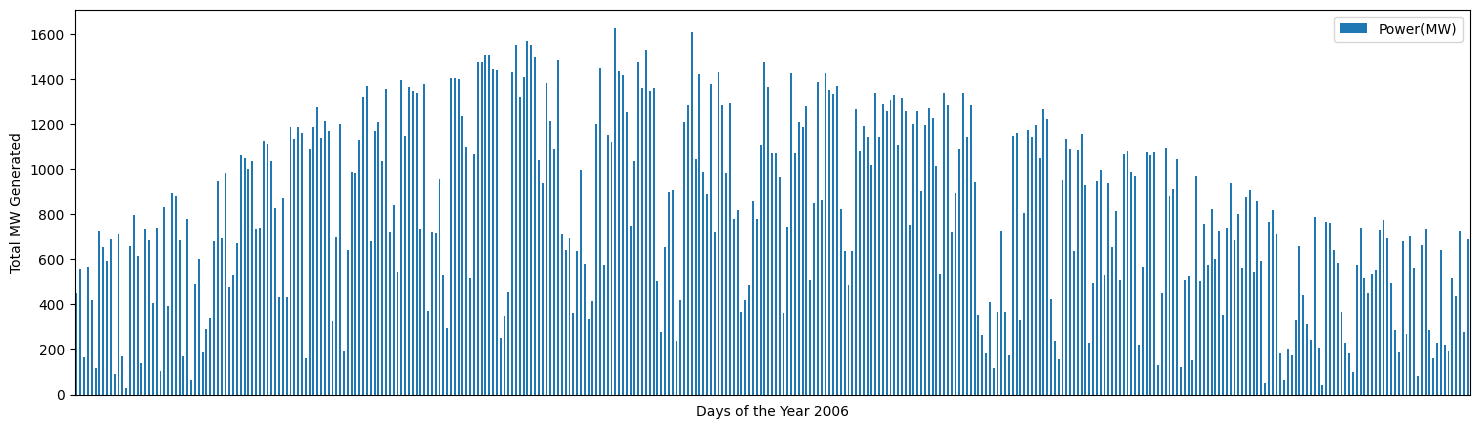

In [18]:
df2 = df.groupby('Date').sum('Power(MW)').reset_index()
df2.plot(kind='bar', x='Date', y='Power(MW)', xlabel='Days of the Year 2006', ylabel='Total MW Generated')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gcf().set_size_inches(18, 5)

Above, we can see a bell curve distribution among the high values, peaking in the summer months, with plenty of days interspersed with much lower values. To try to create a predictive model for total power generated per day, let's load up a separate CSV file containing key weather features for the corresponding time and place: the year 2006 in The Bronx, NY. 

In [19]:
#column_names=['Date', 'TempF', 'TempK', 'Hrs_Daylight', 'Humdity', 'Precipitation']
features_df = pd.read_csv('/Users/tareq/solar_panel_model/Bronx_Weather_2006.csv', header=0)
print(features_df.head())


         Date  TempF       TempK  HrsDaylight  Humidity  Precipitation
0  2006-01-01   37.7  276.316667         9.00      75.2           0.00
1  2006-01-02   42.2  278.816667         9.04      73.7           0.58
2  2006-01-03   37.9  276.427778         9.08      85.2           0.89
3  2006-01-04   34.3  274.427778         9.12      70.4           0.00
4  2006-01-05   42.5  278.983333         9.16      76.5           0.07


Let's merge these two dataframes on Date (2006-01-01 to 2006-12-31) so we can draw our dependent and independent variables from the same place. We'll also drop TempF in favor of TempK, Kelvin units, so we can more accurately capture what it would mean for the temperature to "double", for example.

In [21]:
merge_df = df2.merge(features_df,
                  on ='Date', how='right')
merge_df['Power(MW)'] = df2['Power(MW)']
merge_df = merge_df.drop(['TempF'],axis=1)
print(merge_df.head())
#merge_df.to_csv('Bronx_Weather_Power_2006.csv') optional save

         Date  Power(MW)       TempK  HrsDaylight  Humidity  Precipitation
0  2006-01-01      451.3  276.316667         9.00      75.2           0.00
1  2006-01-02      557.7  278.816667         9.04      73.7           0.58
2  2006-01-03      164.7  276.427778         9.08      85.2           0.89
3  2006-01-04      567.5  274.427778         9.12      70.4           0.00
4  2006-01-05      418.6  278.983333         9.16      76.5           0.07


To train a linear regression model, we can now set the independent variables (X) as every column except Date and Power(MW), and set the dependent variable (y) to the column Power(MW) only. We can separate out a test set from our majority of training data to run predictions on later.

In [44]:
X = merge_df.drop('Power(MW)',axis=1)
X = X.drop('Date',axis=1)
y = merge_df['Power(MW)'].to_numpy().reshape(-1, 1)

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=40)

# fit the LinearRegression model on the train set
model = LinearRegression()
model.fit(X_train, y_train)

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(model.coef_))], axis=1, ignore_index=True)
coefficients.rename(columns={0: 'Feature:', 1: 'Coefficient:'}, inplace=True)

print(coefficients)


        Feature:  Coefficient:
0          TempK      1.598162
1    HrsDaylight    102.127750
2       Humidity    -15.847689
3  Precipitation    -49.077422


As we might expect from these coefficients for each feature, TempK (temperature in Kelvin) and HrsDaylight are positively correlated with the amount of solar power produced, while Humidity and Precipitation are negatively correlated. Now that training is complete, we can run predictions on the test set based on the weather conditions, then compare the model's predictions to the actual values in Difference and % Error.

In [54]:
predictions = model.predict(X_test)

predict_df = pd.DataFrame(y_test)
predict_df.columns = ['ActualValue(MW)']

predict_df['PredValue(MW)'] = predictions
predict_df['PredValue(MW)'] = predict_df['PredValue(MW)'].apply(lambda value:round(value, 1))

predict_df['Difference'] = abs(predictions - y_test)
predict_df['Difference'] = predict_df['Difference'].apply(lambda value:round(value, 1))

predict_df['% Error'] = round(100*(predict_df['Difference']/predict_df['ActualValue(MW)']), 2)

print(predict_df)


    ActualValue(MW)  PredValue(MW)  Difference  % Error
0            1286.4         1083.9       202.5    15.74
1             881.9         1015.7       133.8    15.17
2             812.3          749.2        63.1     7.77
3             994.3          672.9       321.4    32.32
4             494.2          554.8        60.6    12.26
5             689.9          569.6       120.3    17.44
6             367.5          633.2       265.7    72.30
7            1198.4         1015.7       182.7    15.25
8             860.4          845.0        15.4     1.79
9            1435.2         1308.1       127.1     8.86
10           1186.6          865.2       321.4    27.09
11           1185.0         1122.4        62.6     5.28
12           1186.9          927.2       259.7    21.88
13            185.5          183.1         2.4     1.29
14            786.8          697.5        89.3    11.35
15            116.0          523.1       407.1   350.95
16            567.5          301.4       266.1  